### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/trim-filter-messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 过滤与裁剪对话消息（Filtering and Trimming Messages）

## 回顾

到目前为止，我们已经进一步理解了以下内容：

- 如何自定义图状态（Graph State）的数据模式（Schema）
- 如何定义自定义的状态归约器器（State Reducers）
- 如何在一个项目中使用多种图状态 Schema

## 目标

接下来，我们将在 LangGraph 中把这些概念用于实际模型调用。

在后续章节里，我们会逐步构建一个支持长期记忆的聊天机器人。

因为机器人依赖消息来对话，我们先介绍在图状态中处理消息的几种高级方式：过滤（Filter）与裁剪（Trim）。

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

In [2]:
import os, getpass

# 小工具：若环境变量未设置，则在运行时提示手动输入并写入到进程环境变量
# 生产环境建议通过更安全的方式（如 .env、密钥管理服务、CI/CD 注入）设置

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# OpenAI API 密钥（用于 ChatOpenAI 调用）
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[调用追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)。

本笔记会将追踪数据记录到项目 `langchain-academy` 中。

In [3]:
# LangSmith 用于链路追踪与可视化分析
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
# 指定追踪项目名，便于区分不同实验/环境
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


## 将消息作为状态（Messages as State）

首先，我们先定义一些对话消息。

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# 定义一组对话消息（先是 AI，再是人类），用于后续示例
messages = [AIMessage(f"你之前说你在研究海洋哺乳动物，对吗？", name="Bot")]
messages.append(HumanMessage(f"是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance"))
# 以更易读的格式打印消息，便于调试与理解
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？


回顾一下：我们可以直接把这组消息传给聊天模型。

In [5]:
from langchain_openai import ChatOpenAI

# 初始化聊天模型；gpt-4o 仅为示例，可根据账号权限与成本选择其他模型
llm = ChatOpenAI(model="gpt-4o")

# 直接将完整消息历史传入模型（注意：长对话会推高 token 与延迟）
llm.invoke(messages)

AIMessage(content='除了鲸鱼，还有许多其他的海洋哺乳动物值得了解。其中包括：\n\n1. **海豚**：海豚是非常聪明的哺乳动物，以其复杂的社会行为和高水平的智力著称。种类很多，如瓶鼻海豚、虎鲸（也称杀人鲸，实际上是海豚的一种）等。\n\n2. **海豹**：海豹是鳍足类动物，生活在全球范围内的海洋中。常见的种类包括普通海豹、象海豹和北极环斑海豹等。\n\n3. **海狮**：海狮也是鳍足类动物，它们与海豹不同的是可以更灵活地在陆地上行走。加州海狮是最为知名的品种之一。\n\n4. **海象**：海象以其巨大的体型和长长的獠牙而闻名，主要生活在北极地区。\n\n5. **儒艮和海牛**：这些被称为“海牛”的大型草食性哺乳动物主要生活在温暖的沿海水域。它们被认为是美人鱼传说的起源。\n\n6. **北极熊**：虽然不总是被认为是海洋哺乳动物，但北极熊依赖海洋栖息地和海冰以获得食物。\n\n了解这些动物不仅能够帮助我们认识多样化的海洋生态系统，还有助于推动它们的保护和研究工作。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 339, 'prompt_tokens': 45, 'total_tokens': 384, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CEXOnnJySL61wZnbHpFl1kEnmq8HU', 'service_tier': Non

我们可以在一个使用 `MessagesState` 的简单图（Graph）里运行聊天模型。

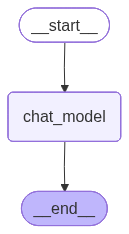

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# 定义一个图节点：接收状态中的所有消息，直接调用聊天模型
# 注意：此处未做任何过滤/裁剪，长对话会不断增长

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# 构建最简图：START -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化图结构
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼，研究海洋哺乳动物时还可以了解以下几类：

1. **海豚（Dolphins）**：海豚是非常聪明的海洋哺乳动物，属于齿鲸亚目，许多种类广泛分布于全球各大洋。

2. **鼠海豚（Porpoises）**：与海豚相似但体型较小，齿形为铲状，与海豚的锥形牙齿不同。

3. **海豹（Seals）**：海豹是鳍脚类动物之一，适应在陆地和海洋环境中生存。

4. **海狮（Sea Lions）和海象（Walrus）**：这些也是鳍脚类动物，海狮以其外露的耳廓与海豹区分开来，而海象有长长的獠牙。

5. **儒艮（Dugongs）和海牛（Manatees）**：这些被统称为海牛目动物，主要生活在浅水中，以海草为食。

6. **北极熊（Polar Bears）**：虽然严格来说属于陆生哺乳动物，但它们依赖海冰狩猎海豹，是重要的海洋食性动物。

7. **海獭（Sea Otters）**：海獭是食肉目动物，生活在北太平洋，主要以海胆、贝类等为食，对海洋生态系统有重要影响。

了解这些动物的生物学特性、生态角色和保护现状，可以帮助更全面地理解海洋生态系统。


## 归约器（Reducer）

在处理消息时，一个实际挑战是管理“长对话”。

如果不加控制，随着对话历史不断增长，模型每次都会接收越来越长的消息列表，导致令牌（token）消耗增大、延迟升高。

为了解决这个问题，我们有几种常用方法。

首先，回顾之前的技巧：使用 `RemoveMessage` 配合 `add_messages` 归约器来删除不需要的历史消息。

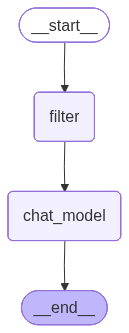

In [8]:
from langchain_core.messages import RemoveMessage

# 过滤节点：仅保留最近 2 条消息，删除更早的历史
# 使用 RemoveMessage + add_messages 归约器的组合语义

def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# 调用节点：将过滤后的消息传给模型

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# 构建图：START -> filter -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("你好。", name="Bot", id="1")]
messages.append(HumanMessage("你好。", name="Lance", id="2"))
messages.append(AIMessage("你之前说你在研究海洋哺乳动物，对吗？", name="Bot", id="3"))
messages.append(HumanMessage("是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者。

7. **北极熊（Polar Bears）**：尽管不是完全生活在海中，但它们经常依赖海冰来捕猎海豹，因此也被视作海洋哺乳动物的一员。

了解这些海洋哺乳动物有助于你对它们在生态系统中所扮演的角色和它们面临的保护问题有更全面的认识。


## 过滤消息（Filtering Messages）

如果你不需要或不想修改图状态本身，可以只对“传入聊天模型的消息列表”进行过滤。

例如，仅把最后一条消息传给模型：`llm.invoke(messages[-1:])`。

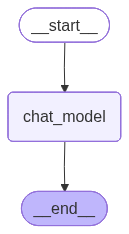

In [10]:
# 仅传入“最后一条消息”给模型，避免把整段历史都送入模型
# 注意：这种方式适用于上下文依赖较弱的问答；若强依赖上下文，请考虑裁剪（trim）而非简单过滤

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

接下来，我们把现有消息列表继续扩展：先加入上面的 LLM 回复，再追加一个追问。

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"再告诉我一些关于独角鲸的事吧！", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼以外，还有许多其他的海洋哺乳动物你可以研究。以下是一些值得了解的海洋哺乳动物类别：

1. **海豚（Dolphins）**：海豚是齿鲸小类下的一员，智商高，社交性强，种类繁多，例如瓶鼻海豚、虎鲸（也称逆戟鲸）等。

2. **鼠海豚（Porpoises）**：与海豚类似，但在体型和生理结构上有一定区别，比如鼠海豚的吻部通常较短，牙齿的形状也不同。

3. **海豹（Seals）**：属于鳍足类动物，既包括无耳海豹（真海豹科）也包括有耳海豹（海狮科和海狗科），海豹依赖陆地或冰面进行繁殖和休息。

4. **海狮（Sea Lions）与海狗（Fur Seals）**：海狮和海狗均属于有耳海豹科，具有外耳壳，可在陆地上行走自如，常见的种类如加州海狮和新西兰毛皮海狮。

5. **海牛（Manatees）与儒艮（Dugongs）**：这些是草食性海洋哺乳类，被称为“海洋牛”，“海牛”生活在沿海与河口水域，而“儒艮”主要分布于温暖的海域。

6. **海獭（Sea Otters）**：主要栖息于北太平洋寒冷水域，以其利用工具（如石头）打开贝类而闻名，是重要的海洋生态系统的调控者

图状态中仍然保存着全部消息。

不过，从 LangSmith 的追踪可以看到：模型实际调用时只使用了最后一条消息。

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## 裁剪消息（Trim Messages）

另一种方式是按令牌数对历史进行“裁剪”（trim）：即通过 [`trim_messages`](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens) 限制用于本次回复的历史消息总令牌数。

- 过滤（filter）：只是事后挑选一部分消息传给模型；
- 裁剪（trim）：从头/尾等策略出发，严格限制可用的历史上下文所占令牌数。

下面演示如何使用 `trim_messages`。

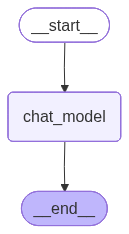

In [14]:
from langchain_core.messages import trim_messages

# 节点：对“历史消息”按令牌数进行裁剪，再调用模型
# - max_tokens：历史消息允许占用的最大 token 数
# - strategy：裁剪策略（"last" 表示优先保留靠后的消息）
# - token_counter：用于估算 token 数的模型或计数器
# - allow_partial：为 False 时，不会截断单条消息的一部分（保证每条消息的完整性）

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

最后，我们再通过 LangSmith 追踪看看本次模型调用的实际入参情况：

https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/d0a1a7a3-9644-4271-82cb-ccadc3ab6969?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=e3584c0f-6c78-4bbd-9178-ab793cdd89e4&peeked_trace=e3584c0f-6c78-4bbd-9178-ab793cdd89e4